In [2]:
import numpy as np
import pandas as pd

import pydicom as dicom
import matplotlib.pylab as plt
import matplotlib.patches as patches

import pickle

import os
from os import listdir
from os.path import isfile, join

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18


from torchsummary import summary

import gc
gc.collect()

import cv2

from sklearn.model_selection import train_test_split

from tqdm import tqdm
from tqdm.auto import tqdm as tqdm_
from tqdm.notebook import tqdm as tqdm_step

from PIL import Image

import matplotlib.pyplot as plt
from IPython.display import clear_output

from graphviz import Digraph

In [3]:
print(f"Cuda доступна {torch.cuda.is_available()}. Версия cuda {torch.version.cuda}")

gpu_id = 0
gpu_str = "cuda:{}".format(gpu_id)
device = torch.device(gpu_str if torch.cuda.is_available() else "cpu")

x_cpu = torch.ones((3, 3))
idx_cpus = set()
devices_cpu = {}
devices_gpu = {}

for idx in range(1000):
    device = torch.device(f"cpu:{idx}")
    x_cpu = x_cpu.to(device)
    if id(x_cpu) not in idx_cpus:
        idx_cpus.add(id(x_cpu))
        devices_cpu[f"cpu:{idx}"] = device
        print("x_cpu:{} device: {} is_cuda: {} id: {}".format(idx, x_cpu.device, x_cpu.is_cuda, id(x_cpu)))
    else:
        break
        
device_count = torch.cuda.device_count()

print("\ndevice_count: {}".format(device_count))

print(f"Используется cuda:{torch.cuda.current_device()}")
print(torch.cuda.device_count())

for idx in range(torch.cuda.device_count()):
    try:
        device = torch.device(f"cuda:{idx}")
        x_gpu = x_cpu.to(device)
        print("x_gpu:\ndevice: {} is_cuda: {} id: {}".format(x_gpu.device, x_gpu.is_cuda, id(x_gpu)))
        device_name = torch.cuda.get_device_name(idx)
        print("\ndevice_name {}: {}".format(idx, device_name))
        #print(torch.cuda.memory_stats(device))
        print(torch.cuda.get_device_capability(idx))
        devices_gpu[f"cuda:{idx}"] = (device_name, device)
    except Exception as e:
        print(f"Карта {idx} не отвечает - {e}")

Cuda доступна True. Версия cuda 10.2
x_cpu:0 device: cpu is_cuda: False id: 140631233327168
x_cpu:1 device: cpu is_cuda: False id: 140631191064144

device_count: 4
Используется cuda:0
4
x_gpu:
device: cuda:0 is_cuda: True id: 140627443461952

device_name 0: Tesla M40 24GB
(5, 2)
x_gpu:
device: cuda:1 is_cuda: True id: 140627443461872

device_name 1: Tesla M40
(5, 2)
x_gpu:
device: cuda:2 is_cuda: True id: 140627443461952

device_name 2: Tesla M40 24GB
(5, 2)
x_gpu:
device: cuda:3 is_cuda: True id: 140627443461872

device_name 3: NVIDIA GeForce GT 1030
(6, 1)


In [4]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [251]:
params = {
    "data_pandas":"",
    "dicom_path":"./CT_HYDROTHORAX_DS_III_SelfTest_10_cases/",
    "size":128,
    'batch_size':8,
    'num_workers':1,
    "epoch":5,
    'device':torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

In [202]:
params['data_pandas'] =  os.path.join(params["dicom_path"], [f for f in listdir(params["dicom_path"]) if isfile(join(params["dicom_path"], f)) if f.split('.')[-1] == 'xlsx'][0])

(512, 512)


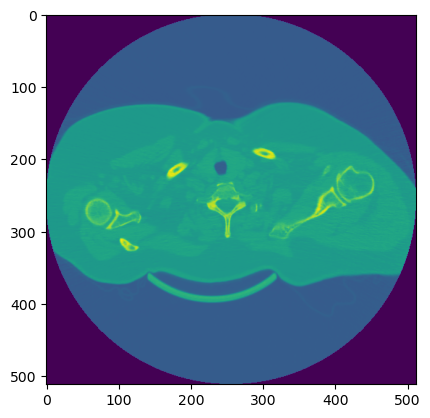

In [203]:
image_path = os.path.join(params["dicom_path"],'1.2.643.5.1.13.13.12.2.77.8252.00021213130709131100130009100900/1.2.643.5.1.13.13.12.2.77.8252.03010208081102131112140005050712/1.2.643.5.1.13.13.12.2.77.8252.01011513131309010807001403090411.dcm')
ds = dicom.dcmread(image_path)
print(np.shape(ds.pixel_array))
plt.imshow(ds.pixel_array);

In [204]:
ds.fix_meta_info

/home/arhitegio/anaconda3/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01011513131309010807001403090411'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/arhitegio/anaconda3/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: The value length (156) exceeds the maximum length of 64 allowed for VR LO.
  warnings.warn(msg)
/home/arhitegio/anaconda3/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00021213130709131100130009100900'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/arhitegio/anaconda3/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.0

<bound method Dataset.fix_meta_info of Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 228
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.643.5.1.13.13.12.2.77.8252.01011513131309010807001403090411
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.392.200036.9116.2.6.1.100
(0002, 0013) Implementation Version Name         SH: 'TM_CT_CMW_V3.00'
(0002, 0016) Source Application Entity Title     SH: 'ANET1_GKB50'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID 

In [205]:
xl = pd.ExcelFile(params["data_pandas"])
xl.sheet_names

['Sheet1']

In [206]:
df = xl.parse(xl.sheet_names[0])
df.head()

,study_id,study_uid,target pathology
0,1,1.2.643.5.1.13.13.12.2.77.8252.130711130205111...,1
1,2,1.2.643.5.1.13.13.12.2.77.8252.120707110114061...,1
2,3,1.2.643.5.1.13.13.12.2.77.8252.000212131307091...,0
3,4,1.2.643.5.1.13.13.12.2.77.8252.101304140007110...,0
4,5,1.2.643.5.1.13.13.12.2.77.8252.041501100205001...,1


In [207]:
df[df.columns[1:]].to_numpy()

array([['1.2.643.5.1.13.13.12.2.77.8252.13071113020511100909130002030902',
        1],
       ['1.2.643.5.1.13.13.12.2.77.8252.12070711011406140711090811071403',
        1],
       ['1.2.643.5.1.13.13.12.2.77.8252.00021213130709131100130009100900',
        0],
       ['1.2.643.5.1.13.13.12.2.77.8252.10130414000711011208060413151200',
        0],
       ['1.2.643.5.1.13.13.12.2.77.8252.04150110020500101206140607040008',
        1],
       ['1.2.643.5.1.13.13.12.2.77.8252.12150202040610130306061415070810',
        1],
       ['1.2.643.5.1.13.13.12.2.77.8252.06021315080301150408151203010510',
        1],
       ['1.2.643.5.1.13.13.12.2.77.8252.06020305101012000608131510110403',
        1],
       ['1.2.643.5.1.13.13.12.2.77.8252.02150609090501100010060615121212',
        1],
       ['1.2.643.5.1.13.13.12.2.77.8252.07011014020814091406030702131205',
        1]], dtype=object)

In [208]:
files = [{"study_uid":dp.split('/')[-2], "path_dicom":os.path.join(dp, f)} for dp, dn, filenames in os.walk(params["dicom_path"]) for f in filenames if os.path.splitext(f)[1] == '.dcm']

In [209]:
df_ = pd.DataFrame(files)

In [210]:
df

,study_id,study_uid,target pathology
0,1,1.2.643.5.1.13.13.12.2.77.8252.130711130205111...,1
1,2,1.2.643.5.1.13.13.12.2.77.8252.120707110114061...,1
2,3,1.2.643.5.1.13.13.12.2.77.8252.000212131307091...,0
3,4,1.2.643.5.1.13.13.12.2.77.8252.101304140007110...,0
4,5,1.2.643.5.1.13.13.12.2.77.8252.041501100205001...,1
5,6,1.2.643.5.1.13.13.12.2.77.8252.121502020406101...,1
6,7,1.2.643.5.1.13.13.12.2.77.8252.060213150803011...,1
7,8,1.2.643.5.1.13.13.12.2.77.8252.060203051010120...,1
8,9,1.2.643.5.1.13.13.12.2.77.8252.021506090905011...,1
9,10,1.2.643.5.1.13.13.12.2.77.8252.070110140208140...,1


In [211]:
df_

,study_uid,path_dicom
0,1.2.643.5.1.13.13.12.2.77.8252.060203051010120...,./CT_HYDROTHORAX_DS_III_SelfTest_10_cases/1.2....
1,1.2.643.5.1.13.13.12.2.77.8252.060203051010120...,./CT_HYDROTHORAX_DS_III_SelfTest_10_cases/1.2....
2,1.2.643.5.1.13.13.12.2.77.8252.060203051010120...,./CT_HYDROTHORAX_DS_III_SelfTest_10_cases/1.2....
3,1.2.643.5.1.13.13.12.2.77.8252.060203051010120...,./CT_HYDROTHORAX_DS_III_SelfTest_10_cases/1.2....
4,1.2.643.5.1.13.13.12.2.77.8252.060203051010120...,./CT_HYDROTHORAX_DS_III_SelfTest_10_cases/1.2....
...,...,...
4357,1.2.643.5.1.13.13.12.2.77.8252.021506090905011...,./CT_HYDROTHORAX_DS_III_SelfTest_10_cases/1.2....
4358,1.2.643.5.1.13.13.12.2.77.8252.021506090905011...,./CT_HYDROTHORAX_DS_III_SelfTest_10_cases/1.2....
4359,1.2.643.5.1.13.13.12.2.77.8252.021506090905011...,./CT_HYDROTHORAX_DS_III_SelfTest_10_cases/1.2....
4360,1.2.643.5.1.13.13.12.2.77.8252.021506090905011...,./CT_HYDROTHORAX_DS_III_SelfTest_10_cases/1.2....


In [212]:
data = df_.merge(df[df.columns[1:]], how='inner', on="study_uid")

In [213]:
data

,study_uid,path_dicom,target pathology
0,1.2.643.5.1.13.13.12.2.77.8252.060203051010120...,./CT_HYDROTHORAX_DS_III_SelfTest_10_cases/1.2....,1
1,1.2.643.5.1.13.13.12.2.77.8252.060203051010120...,./CT_HYDROTHORAX_DS_III_SelfTest_10_cases/1.2....,1
2,1.2.643.5.1.13.13.12.2.77.8252.060203051010120...,./CT_HYDROTHORAX_DS_III_SelfTest_10_cases/1.2....,1
3,1.2.643.5.1.13.13.12.2.77.8252.060203051010120...,./CT_HYDROTHORAX_DS_III_SelfTest_10_cases/1.2....,1
4,1.2.643.5.1.13.13.12.2.77.8252.060203051010120...,./CT_HYDROTHORAX_DS_III_SelfTest_10_cases/1.2....,1
...,...,...,...
4357,1.2.643.5.1.13.13.12.2.77.8252.021506090905011...,./CT_HYDROTHORAX_DS_III_SelfTest_10_cases/1.2....,1
4358,1.2.643.5.1.13.13.12.2.77.8252.021506090905011...,./CT_HYDROTHORAX_DS_III_SelfTest_10_cases/1.2....,1
4359,1.2.643.5.1.13.13.12.2.77.8252.021506090905011...,./CT_HYDROTHORAX_DS_III_SelfTest_10_cases/1.2....,1
4360,1.2.643.5.1.13.13.12.2.77.8252.021506090905011...,./CT_HYDROTHORAX_DS_III_SelfTest_10_cases/1.2....,1


In [214]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4362 entries, 0 to 4361
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   study_uid         4362 non-null   object
 1   path_dicom        4362 non-null   object
 2   target pathology  4362 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 136.3+ KB


In [264]:
params['all_class'] = np.unique(data["target pathology"])

In [265]:
data.groupby(data["study_uid"]).agg({"target pathology":["count"]})

,target pathology
,count
study_uid,
1.2.643.5.1.13.13.12.2.77.8252.00021213130709131100130009100900,426
1.2.643.5.1.13.13.12.2.77.8252.02150609090501100010060615121212,211
1.2.643.5.1.13.13.12.2.77.8252.04150110020500101206140607040008,2
1.2.643.5.1.13.13.12.2.77.8252.06020305101012000608131510110403,476
1.2.643.5.1.13.13.12.2.77.8252.06021315080301150408151203010510,2
1.2.643.5.1.13.13.12.2.77.8252.07011014020814091406030702131205,599
1.2.643.5.1.13.13.12.2.77.8252.10130414000711011208060413151200,651
1.2.643.5.1.13.13.12.2.77.8252.12070711011406140711090811071403,714


In [266]:
data.groupby(data["target pathology"]).agg({"study_uid":["count"]})

,study_uid
,count
target pathology,
0,1077
1,3285


<AxesSubplot:>

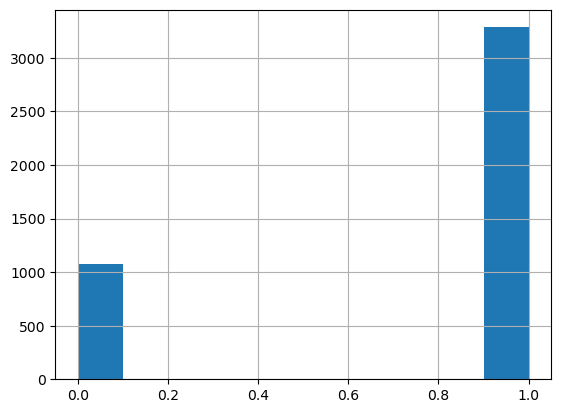

In [267]:
data["target pathology"].hist()

In [268]:
train_df, valid_df = train_test_split(data, test_size=0.2, random_state=43)

In [269]:
dicom_path, label = train_df.iloc[0]['path_dicom'], train_df.iloc[0]['target pathology']

In [270]:
dicom_image = Image.fromarray(dicom.dcmread(dicom_path).pixel_array)

In [271]:
arr = dicom.dcmread(dicom_path).pixel_array

In [272]:
np.min(arr), np.max(arr), np.median(arr), np.mean(arr)

(-2048, 2338, -846.0, -780.0410270690918)

In [273]:
glb_ = { "min":[], "max":[], "mean":[], "median":[] }

In [274]:
pbar_progress = tqdm_step(range(len(train_df)), desc="Прогресс")

for idx in pbar_progress:
    dicom_path, label = train_df.iloc[idx]['path_dicom'], train_df.iloc[idx]['target pathology']
    arr = dicom.dcmread(dicom_path).pixel_array
    glb_['min'].append(np.min(arr))
    glb_['max'].append(np.max(arr))
    glb_['median'].append(np.median(arr))
    glb_['mean'].append(np.mean(arr))

Прогресс:   0%|          | 0/3489 [00:00<?, ?it/s]

In [424]:
class ImageDataset(Dataset):
    def __init__(self, data_df, transform=None):

        self.data_df = data_df
        self.transform = transform
        
    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        
        dicom_path, label = self.data_df.iloc[idx]['path_dicom'], self.data_df.iloc[idx]['target pathology']
        #print(np.shape(dicom.dcmread(dicom_path).pixel_array))
        dicom_arr = dicom.dcmread(dicom_path).pixel_array
        while len(np.shape(dicom_arr)) > 2:
            dicom_arr = dicom_arr[0, ...]
            
        dicom_image = Image.fromarray(dicom_arr)
        #print(params['size'])
        #print(np.shape(dicom_image), np.min(dicom_image), np.max(dicom_image), np.mean(dicom_image), np.median(dicom_image))
        dicom_image = dicom_image.resize((params['size'], params['size']))#, resample=Image.Resampling.BOX)
        #print(np.shape(dicom_image))
        #print(1)
        if self.transform:
            dicom_image = self.transform(dicom_image)
        #print(2)
        #print(torch.typename(dicom_image))
        return dicom_image.float(), torch.tensor(np.array([1.0 if idx == label else 0.0 for idx, e in enumerate(range(len(params['all_class'])))])), dicom_path

In [425]:
df_gbl = pd.DataFrame(glb_)

In [426]:
df_gbl

,min,max,mean,median
0,-2048,2338,-780.041027,-846.0
1,0,2823,522.904044,260.0
2,-2048,1417,-724.846733,-775.0
3,0,3003,586.613597,684.0
4,-2048,1429,-694.916576,-193.0
...,...,...,...,...
3484,-2048,1435,-808.421112,-843.0
3485,-2048,1503,-760.244431,-885.0
3486,-2048,1508,-733.720692,-885.0
3487,-2048,1310,-588.244072,-121.0


In [427]:
train_transform = transforms.Compose([
    #trf.ToPILImage(),
    #transforms.Resize((params['size'], params['size'])),
    #trf.Resize((512, 512)),
    #transforms.Resize((int(params['size'] * 1.3), int(params['size'] * 1.3))),
    #trf.Resize((int(params['size']), int(params['size']))),
    #transforms.RandomCrop((params['size'], params['size'])),
    transforms.RandomRotation(degrees=5.0, fill=np.min(df_gbl['min'])),
    transforms.RandomAffine(degrees=(-2,2), translate=(0, 0.15), scale=(0.90, 1.0), fill=np.min(df_gbl['min'])),
    #trf.RandomApply(transforms=[trf.ElasticTransform(alpha=50.0)], p=0.5),
    transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.02, hue=0.02), 
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225]),
])
valid_transform = transforms.Compose([
    #transforms.ToPILImage(),
    #transforms.Resize((params['size'], params['size'])),
    #transforms.RandomResizedCrop(params['size']),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225]),
])

In [428]:
train_df.groupby('target pathology').agg({"study_uid":["count"]}), valid_df.groupby('target pathology').agg({"study_uid":["count"]})

(                 study_uid
                      count
 target pathology          
 0                      879
 1                     2610,
                  study_uid
                      count
 target pathology          
 0                      198
 1                      675)

In [429]:
train_dataset = ImageDataset(train_df, train_transform)
valid_dataset = ImageDataset(valid_df, valid_transform)

In [430]:
np.shape(train_dataset[0][0])

torch.Size([1, 128, 128])

In [431]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=params['batch_size'],
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=params['num_workers'])

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=params['batch_size'],
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=params['num_workers'])

In [432]:
batch_size = 4
epochs = 10
epoch_lapse = 50
threshold = 0.5
sample_size = None

In [433]:
def metric_accuracy(y_true, pred, device):
    #print(np.shape(y_true))
    #print(np.shape(torch.argmax(y_true, dim=0)))
    #print(np.shape(torch.argmax(y_true, dim=-1)))
    #print(torch.argmax(y_true, dim=0) == torch.argmax(pred, dim=0).float())
    return torch.mean((torch.argmax(y_true, dim=-1) == torch.argmax(pred, dim=-1)).float())

In [434]:
class DownSampling(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, device):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels, padding=1)
        self.conv1.to(device)
        self.bn2d1 = torch.nn.BatchNorm2d(out_channels)
        self.bn2d1.to(device)
        self.conv2 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels, padding=1)
        self.conv2.to(device)
        self.bn2d2 = torch.nn.BatchNorm2d(out_channels)
        self.bn2d2.to(device)

    def forward(self, inp):
        out = torch.nn.functional.relu(self.conv1(inp))
        out = self.bn2d1(out)
        out = torch.nn.functional.relu(self.conv2(out))
        out = self.bn2d2(out)
        return out

In [435]:
class FinalBlock(nn.Module):
    def __init__(self, in_channels, mid_channel, out_channels, kernel_size, device):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=1)
        self.conv1.to(device)
        self.bn2d1 = torch.nn.BatchNorm2d(mid_channel)
        self.bn2d1.to(device)
        self.conv2 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding=1)
        self.conv2.to(device)
        self.bn2d2 = torch.nn.BatchNorm2d(mid_channel)
        self.bn2d2.to(device)
        self.conv3 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1)
        self.conv3.to(device)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(1083, 128)
        self.linear1.to(device)
        self.linear2 = nn.Linear(128, 32)
        self.linear2.to(device)
        self.linear3 = nn.Linear(32, len(params["all_class"]))
        self.linear3.to(device)
        
    def forward(self, inp):
        out = torch.nn.functional.relu(self.conv1(inp))
        out = self.bn2d1(out)
        out = torch.nn.functional.relu(self.conv2(out))
        out = self.bn2d2(out)
        out = torch.sigmoid(self.conv3(out))
        out = self.flatten(out)
        out = torch.sigmoid(self.linear1(out))
        out = torch.sigmoid(self.linear2(out))
        out = torch.nn.functional.softmax(self.linear3(out))
        return out

In [436]:
class UNet(nn.Module):    
    def __init__(self, in_channels, out_channels, device):
        super(UNet, self).__init__()
        self.conv1 = DownSampling(in_channels, 24, 3, device)
        self.conv1.to(device)
        self.conv2 = DownSampling(24, 16, 3, device)
        self.conv2.to(device)
        self.conv3 = DownSampling(16, 12, 3, device)
        self.conv3.to(device)
        self.final = FinalBlock(12, 8, 3, out_channels, device)
        self.final.to(device)
        self.conv_maxpool = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_maxpool.to(device)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv_maxpool(x)
        x = self.conv2(x)
        x = self.conv_maxpool(x)
        x = self.conv3(x)
        x = self.conv_maxpool(x)
        x = self.final(x)
        return x

In [437]:
def step(inputs, labels, optimizer, criterion, device, is_train=True):
    #if is_train:
    optimizer.zero_grad()

    outputs = unet(inputs)
    #print(np.shape(outputs), np.shape(labels))
    #outputs = outputs.permute(0, 2, 3, 1)
    #labels = labels.permute(0, 2, 3, 1)
    
    #loss = criterion(torch.argmax(outputs, dim=0).float(), torch.argmax(labels.float(), dim=0).float())
    loss = criterion(outputs, labels.float())
    
    if is_train:
        loss.backward()
        optimizer.step()
    return loss.item(), metric_accuracy(labels, outputs, device).item()

In [438]:
learning_rate = 0.0001

In [439]:
unet = UNet(in_channels=1,out_channels=np.shape(params['all_class'])[-1], device=params["device"])
#if params['device'] != "cpu":
#unet = unet.to(params["device"])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(unet.parameters(), lr = learning_rate)

In [440]:
unet.to(params["device"])

UNet(
  (conv1): DownSampling(
    (conv1): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2d1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2d2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): DownSampling(
    (conv1): Conv2d(24, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2d1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2d2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): DownSampling(
    (conv1): Conv2d(16, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2d1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(12, 12, kernel_size=(3, 3), stri

In [441]:
acc_train_total = []
loss_train_total = []
acc_val_total = []
loss_val_total = []

In [442]:
try:
    print(unet.load_state_dict(torch.load('./best_model_gidratorax.mdl')))
except:
    print("Модель не загрузилась")

Модель не загрузилась


In [443]:
try:
    acc_train_total = list(np.load('acc_gidratorax_train_total.npy'))
    loss_train_total = list(np.load('loss_gidratorax_train_total.npy'))
    acc_val_total = list(np.load('acc_gidratorax_val_total.npy'))
    loss_val_total = list(np.load('loss_gidratorax_val_total.npy'))
except:
    print("Данные не загрузилась")

Данные не загрузилась


In [444]:
learning_rate = 0.0001

In [445]:
criterion = nn.BCELoss()

In [446]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(unet.parameters(), lr = learning_rate)

In [447]:
%%time

acc_train  = []
loss_train = []
acc_val    = []
loss_val   = []
batch_loss = 0
metric_acc = 0
pbar_epochs = tqdm_step(range(params["epoch"]), desc="Epochs")
for _ in pbar_epochs:
    unet.train()
    bar_train_loss = []
    bar_train_acc = []
    pbar_steps = tqdm_step(train_loader, desc="Training")
    for batch_train_x, batch_train_y, batch_train_name_file in pbar_steps:
        #batch_train_x = torch.from_numpy(x_train[i * batch_size : (i + 1) * batch_size, ...]).float()
        #batch_train_y = torch.from_numpy(y_train[i * batch_size : (i + 1) * batch_size]).long()
        #print(np.shape(batch_train_x), np.shape(batch_train_y), np.shape(batch_train_name_file))
        #if use_gpu:
        #try:
            batch_train_x = batch_train_x.to(params["device"])
            batch_train_y = batch_train_y.to(params["device"])
            batch_loss, metric_acc = step(batch_train_x, batch_train_y, optimizer, criterion, params["device"], is_train=True)
            bar_train_loss.append(batch_loss)
            bar_train_acc.append(metric_acc)
            pbar_steps.postfix = f"loss = {batch_loss}, acc = {metric_acc*100}%, loss_mean = {np.mean(bar_train_loss)}, acc_mean = {np.mean(bar_train_acc)*100}%"     
            torch.cuda.empty_cache()
            gc.collect()
        #except Exception as e:
        #    pass
        #break
    loss_train.append(np.mean(bar_train_loss))
    acc_train.append(np.mean(bar_train_acc))
    
    unet.eval()
    with torch.no_grad():
        pbar_vals = tqdm_step(valid_loader, desc="Predicting")
        bar_val_loss = []
        bar_val_acc = []
        for batch_val_x, batch_val_y, batch_val_name_file in pbar_vals:
            #try:
                #print(np.shape(batch_val_x), np.shape(batch_val_y), np.shape(batch_val_name_file))
                #batch_val_x = torch.from_numpy(x_val[i * batch_size : (i + 1) * batch_size, ...]).float()
                #batch_val_y = torch.from_numpy(y_val[i * batch_size : (i + 1) * batch_size]).long()
                #if use_gpu:
                batch_val_x = batch_val_x.to(params["device"])
                batch_val_y = batch_val_y.to(params["device"])
                batch_loss, metric_acc = step(batch_val_x, batch_val_y, optimizer, criterion, params["device"], is_train=False)
                bar_val_loss.append(batch_loss)
                bar_val_acc.append(metric_acc)
                pbar_vals.postfix = f"loss = {batch_loss},  acc = {metric_acc*100}%, loss_mean = {np.mean(bar_val_loss)}, acc_mean = {np.mean(bar_val_acc)*100}%"
                torch.cuda.empty_cache()
                gc.collect()
            #except Exception as e:
            #    print(e)
    loss_val.append(np.mean(bar_val_loss))
    acc_val.append(np.mean(bar_val_acc))
    pbar_epochs.postfix = f"train_loss = {loss_train[-1]}, train_acc = {acc_train[-1]*100}%, val_loss = {loss_val[-1]}, val_acc = {acc_val[-1]*100}%"
acc_train_total.append(acc_train)
loss_train_total.append(loss_train)
acc_val_total.append(acc_val)
loss_val_total.append(loss_val)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/437 [00:00<?, ?it/s]

/tmp/ipykernel_10376/3022222193.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(self.linear3(out))
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe66f038940>
Traceback (most recent call last):
  File "/home/arhitegio/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/arhitegio/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/arhitegio/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Predicting:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/437 [00:00<?, ?it/s]

Predicting:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/437 [00:00<?, ?it/s]

Predicting:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/437 [00:00<?, ?it/s]

Predicting:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/437 [00:00<?, ?it/s]

Predicting:   0%|          | 0/110 [00:00<?, ?it/s]

CPU times: user 8min 8s, sys: 26.1 s, total: 8min 34s
Wall time: 8min 43s


In [448]:
%%time

acc_train  = []
loss_train = []
acc_val    = []
loss_val   = []
batch_loss = 0
metric_acc = 0
pbar_epochs = tqdm_step(range(params["epoch"]), desc="Epochs")
for _ in pbar_epochs:
    unet.train()
    bar_train_loss = []
    bar_train_acc = []
    pbar_steps = tqdm_step(train_loader, desc="Training")
    for batch_train_x, batch_train_y, batch_train_name_file in pbar_steps:
        #batch_train_x = torch.from_numpy(x_train[i * batch_size : (i + 1) * batch_size, ...]).float()
        #batch_train_y = torch.from_numpy(y_train[i * batch_size : (i + 1) * batch_size]).long()
        #print(np.shape(batch_train_x), np.shape(batch_train_y), np.shape(batch_train_name_file))
        #if use_gpu:
        batch_train_x = batch_train_x.to(params["device"])
        batch_train_y = batch_train_y.to(params["device"])
        batch_loss, metric_acc = step(batch_train_x, batch_train_y, optimizer, criterion, params["device"], is_train=True)
        bar_train_loss.append(batch_loss)
        bar_train_acc.append(metric_acc)
        pbar_steps.postfix = f"loss = {batch_loss}, acc = {metric_acc*100}%, loss_mean = {np.mean(bar_train_loss)}, acc_mean = {np.mean(bar_train_acc)*100}%"     
        torch.cuda.empty_cache()
        gc.collect()
        #break
    loss_train.append(np.mean(bar_train_loss))
    acc_train.append(np.mean(bar_train_acc))
    
    unet.eval()
    with torch.no_grad():
        pbar_vals = tqdm_step(valid_loader, desc="Predicting")
        bar_val_loss = []
        bar_val_acc = []
        for batch_val_x, batch_val_y, batch_val_name_file in pbar_vals:
            #try:
                #print(np.shape(batch_val_x), np.shape(batch_val_y), np.shape(batch_val_name_file))
                #batch_val_x = torch.from_numpy(x_val[i * batch_size : (i + 1) * batch_size, ...]).float()
                #batch_val_y = torch.from_numpy(y_val[i * batch_size : (i + 1) * batch_size]).long()
                #if use_gpu:
                batch_val_x = batch_val_x.to(params["device"])
                batch_val_y = batch_val_y.to(params["device"])
                batch_loss, metric_acc = step(batch_val_x, batch_val_y, optimizer, criterion, params["device"], is_train=False)
                bar_val_loss.append(batch_loss)
                bar_val_acc.append(metric_acc)
                pbar_vals.postfix = f"loss = {batch_loss},  acc = {metric_acc*100}%, loss_mean = {np.mean(bar_val_loss)}, acc_mean = {np.mean(bar_val_acc)*100}%"
                torch.cuda.empty_cache()
                gc.collect()
            #except Exception as e:
            #    print(e)
    loss_val.append(np.mean(bar_val_loss))
    acc_val.append(np.mean(bar_val_acc))
    pbar_epochs.postfix = f"train_loss = {loss_train[-1]}, train_acc = {acc_train[-1]*100}%, val_loss = {loss_val[-1]}, val_acc = {acc_val[-1]*100}%"
acc_train_total.append(acc_train)
loss_train_total.append(loss_train)
acc_val_total.append(acc_val)
loss_val_total.append(loss_val)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/437 [00:00<?, ?it/s]

/tmp/ipykernel_10376/3022222193.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(self.linear3(out))


Predicting:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/437 [00:00<?, ?it/s]

Predicting:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/437 [00:00<?, ?it/s]

Predicting:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/437 [00:00<?, ?it/s]

Predicting:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/437 [00:00<?, ?it/s]

Predicting:   0%|          | 0/110 [00:00<?, ?it/s]

CPU times: user 8min 13s, sys: 26.5 s, total: 8min 40s
Wall time: 8min 48s


In [449]:
arr_pred = []
y_true = []
y_pred = []
for idx in range(len(valid_dataset)):
    x, y, name_file = valid_dataset[idx]
    x = torch.tensor(np.array([x.detach().cpu().numpy()])).to(params["device"])
    y_p = unet(x.to(params["device"])).squeeze(0).detach().cpu().numpy()
    y_true.append(np.argmax(y).item())
    y_pred.append(np.argmax(y_p))
    arr_pred.append(np.argmax(y).item() == np.argmax(y_p))

/tmp/ipykernel_10376/3022222193.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(self.linear3(out))


In [450]:
len([e for e in zip(y_true, y_pred) if e[0] == e[1]])

859

In [451]:
len([e for e in zip(y_true, y_pred) if e[0] == e[1] and e[0] == 1])

675

In [452]:
len([e for e in zip(y_true, y_pred) if e[0] != e[1]])

14

In [453]:
from sklearn.metrics import f1_score, accuracy_score

In [454]:
print(f"F1 = {f1_score(y_true, y_pred, average='macro')}, точность = {accuracy_score(y_true, y_pred)}")

F1 = 0.976543427860773, точность = 0.983963344788087


In [455]:
print("Максимальная точность на тренировочных примерах: ")
print("точность: " + str(np.max(np.hstack(acc_train_total))) + ", loss:" + str(np.max(np.hstack(loss_train_total))))

Максимальная точность на тренировочных примерах: 
точность: 0.9902745995423341, loss:0.5934787325100713


In [456]:
print("Максимальная точность на тестовых примерах: ")
print("точность: " + str(np.max(np.hstack(acc_val_total))) + ", loss:" + str(np.max(np.hstack(loss_val_total))))

Максимальная точность на тестовых примерах: 
точность: 0.9954545454545455, loss:0.5507662277330052


In [457]:
print("Средняя точность на тренировочных из 10 последних примеров: ")
print("точность: " + str(np.mean(np.hstack(acc_train_total[-10:-1]))) + ", loss:" + str(np.mean(np.hstack(loss_train_total[-10:-1]))))

Средняя точность на тренировочных из 10 последних примеров: 
точность: 0.8928489702517164, loss:0.4431965646400059


In [458]:
print("Средняя точность на тестовых из 10 последних примеров: ")
print("точность: " + str(np.mean(np.hstack(acc_val_total[-10:-1]))) + ", loss:" + str(np.mean(np.hstack(loss_val_total[-10:-1]))))

Средняя точность на тестовых из 10 последних примеров: 
точность: 0.8843181818181817, loss:0.43849006343971597


In [459]:
acc_train_total = [e for e in acc_train_total if type(e) == list]
acc_val_total = [e for e in acc_val_total if type(e) == list]

In [460]:
loss_train_total = [e for e in loss_train_total if type(e) == list]
loss_val_total = [e for e in loss_val_total if type(e) == list]

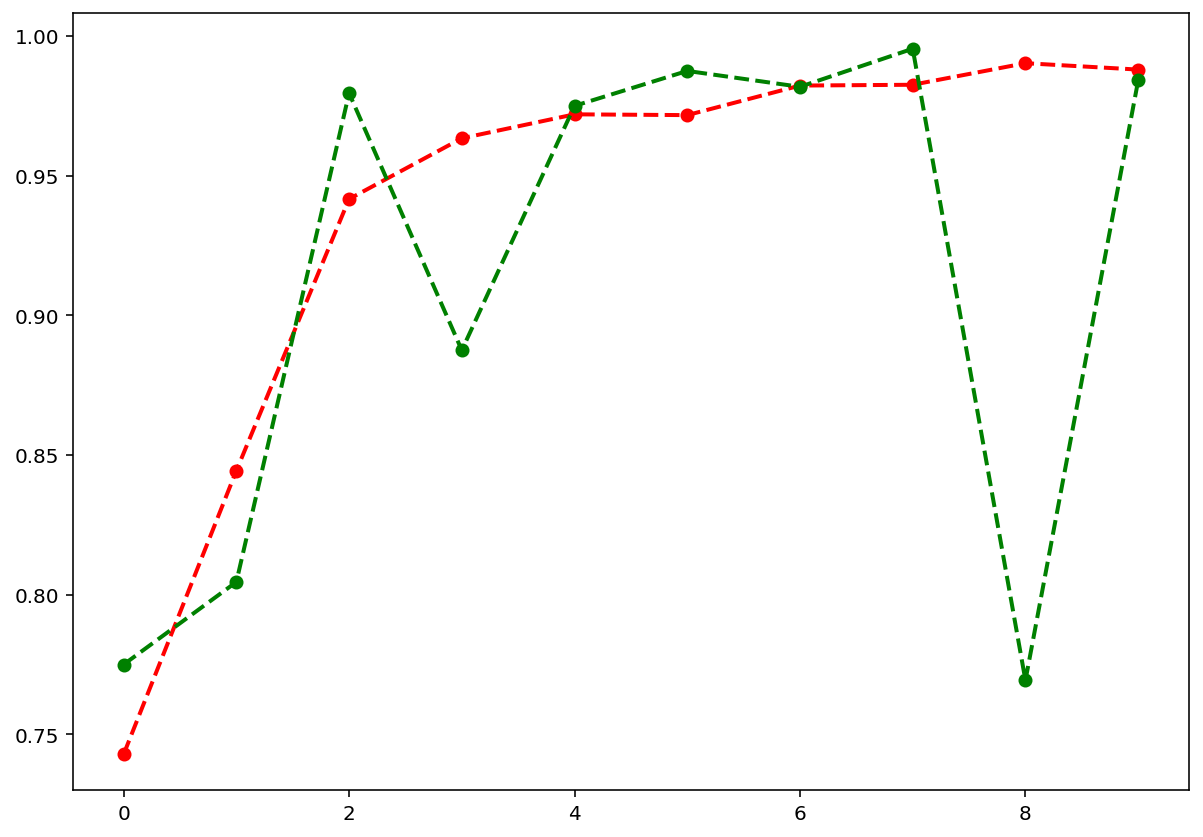

In [461]:
plt.figure(figsize=(10,7), dpi=144)
plt.plot([e for e in range(np.shape(np.hstack(acc_train_total))[0])], np.hstack(acc_train_total), color='red', marker='o', linestyle='dashed', linewidth=2, markersize=6)
plt.plot([e for e in range(np.shape(np.hstack(acc_val_total))[0])], np.hstack(acc_val_total), color='green', marker='o', linestyle='dashed', linewidth=2, markersize=6)
plt.show()

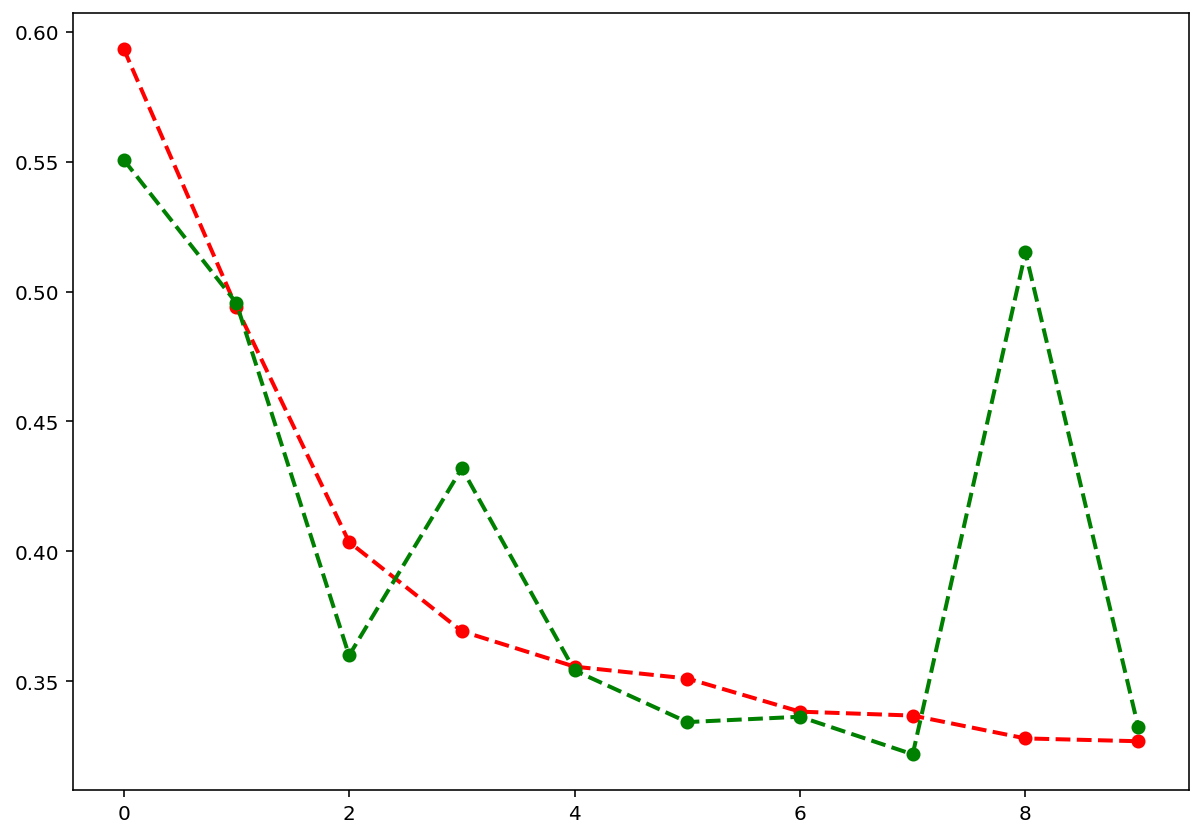

In [462]:
plt.figure(figsize=(10,7), dpi=144)
plt.plot([e for e in range(np.shape(np.hstack(loss_train_total))[0])], np.hstack(loss_train_total), color='red', marker='o', linestyle='dashed', linewidth=2, markersize=6)
plt.plot([e for e in range(np.shape(np.hstack(loss_val_total))[0])], np.hstack(loss_val_total), color='green', marker='o', linestyle='dashed', linewidth=2, markersize=6)
plt.show()

In [463]:
from os import listdir
from os.path import isfile, join

In [464]:
mypath = "./test"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles

['1.2.643.5.1.13.13.12.2.77.8252.01010008061304130311040203131009.dcm',
 '1.2.643.5.1.13.13.12.2.77.8252.02011304130213021315121410130813.dcm',
 '1.2.643.5.1.13.13.12.2.77.8252.01040204110313021013141511080103.dcm',
 '1.2.643.5.1.13.13.12.2.77.8252.02051402081010000101121313150003.dcm',
 '1.2.643.5.1.13.13.12.2.77.8252.14060904040710080600131311130902.dcm',
 '1.2.643.5.1.13.13.12.2.77.8252.12080010000502111105130700130812.dcm',
 '1.2.643.5.1.13.13.12.2.77.8252.00070212030213021413020500030609.dcm',
 '1.2.643.5.1.13.13.12.2.77.8252.04031412011012130402100815090814.dcm',
 '1.2.643.5.1.13.13.12.2.77.8252.06111303110312050011031304000600.dcm',
 '1.2.643.5.1.13.13.12.2.77.8252.15150812151001080111020006111306.dcm',
 '1.2.643.5.1.13.13.12.2.77.8252.00030109070112140207030503070706.dcm',
 '1.2.643.5.1.13.13.12.2.77.8252.05140112080502120900060001021310.dcm',
 '1.2.643.5.1.13.13.12.2.77.8252.15010608071312121001140606091012.dcm',
 '1.2.643.5.1.13.13.12.2.77.8252.0101130000120712040900140207020

In [465]:
params["dicom_path"]

'./CT_HYDROTHORAX_DS_III_SelfTest_10_cases/'

In [473]:
df_test = pd.DataFrame([{"study_uid":f, "path_dicom":os.path.join(dp, f), "target pathology":0} for dp, dn, filenames in os.walk(mypath) for f in onlyfiles if os.path.splitext(f)[1] == '.dcm'])

In [474]:
test_dataset = ImageDataset(df_test, valid_transform)
test_dataset

In [475]:
arr_pred_test = []
y_true_test = []
y_pred_test = []
for idx in range(len(test_dataset)):
    x, y, name_file = test_dataset[idx]
    x = torch.tensor(np.array([x.detach().cpu().numpy()])).to(params["device"])
    y_p = unet(x.to(params["device"])).squeeze(0).detach().cpu().numpy()
    y_true_test.append(np.argmax(y).item())
    y_pred_test.append(np.argmax(y_p))
    arr_pred_test.append(np.argmax(y).item() == np.argmax(y_p))

/tmp/ipykernel_10376/3022222193.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(self.linear3(out))


In [479]:
np.unique(y_true_test)

array([0])

In [480]:
np.unique(y_pred_test)

array([1])

In [476]:
print(f"F1 = {f1_score(y_true_test, y_pred_test, average='macro')}, точность = {accuracy_score(y_true_test, y_pred_test)}")

F1 = 0.0, точность = 0.0
